In [14]:
from pathlib import Path
from llama_index.core import Settings
from llama_index.embeddings.fastembed import FastEmbedEmbedding
from llama_index.llms.anthropic import Anthropic
from unstructured.partition.pdf import partition_pdf

In [15]:
Settings.embed_model = FastEmbedEmbedding(model_name="BAAI/bge-small-en-v1.5")
Settings.llm = Anthropic(model="claude-3-opus-20240229")

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

model_optimized.onnx:   0%|          | 0.00/66.5M [00:00<?, ?B/s]

In [9]:
input_image_path = Path("extracted_images")

for path in [input_image_path]:
    if not path.exists():
        Path.mkdir(path)

print("Environment prepared successfully!")

Environment prepared successfully!


Parsing the PDFs with `unstructured`. The texts will be extrated using tesseract ocr in the background.

In [21]:
from concurrent.futures import ProcessPoolExecutor

def process_pdf(file):
    def extract_text(elements):
        text_content = ""
        count = 0
        for element in elements:
            if "unstructured.documents.elements.Header" in str(type(element)):
                if count > 0:
                    continue
                else:
                    count += 1
                text_content += "\n \n"
            if "unstructured.documents.elements.Title" in str(type(element)):
                text_content += "\n \n"

            text_content += str(element) + "\n"
        return text_content

    filename, _ = file.split(".")
    print(f"Processing {file}")
    raw_pdf_elements = partition_pdf(
        filename=file,
        strategy="auto",
        extract_images_in_pdf=True,
        extract_image_block_types=["Image", "Table"],
        extract_image_block_to_payload=False,
        extract_image_block_output_dir=f"input_images_vol{filename[-1]}",
        infer_table_structure=True,
    )
    text_content = extract_text(raw_pdf_elements)
    output_file = filename + ".txt"
    with open(output_file, "w") as f:
        f.write(text_content)
    print(f"Text content successfully written to {output_file}")

files = ["anatomy_vol_1.pdf", "anatomy_vol_2.pdf", "anatomy_vol_3.pdf"]

# with ProcessPoolExecutor() as executor:
#     executor.map(process_pdf, files)

## Display images

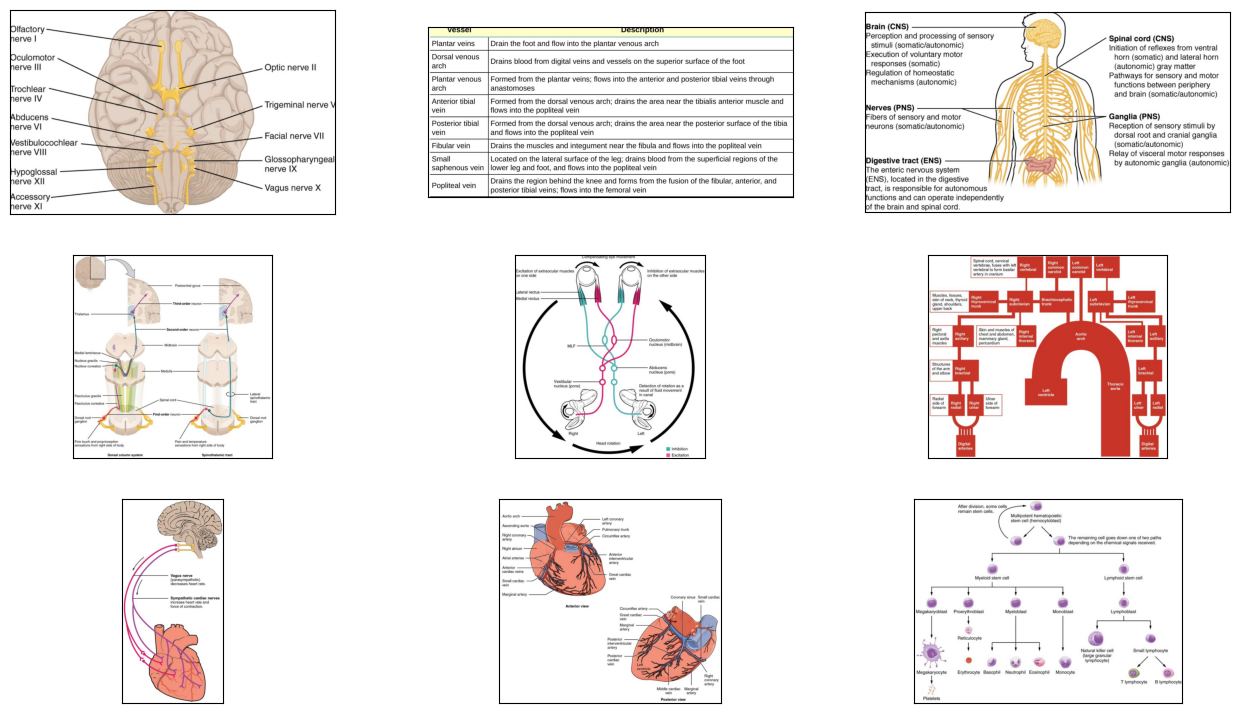

In [31]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir("./input_images_vol2"):
    image_paths.append(str(os.path.join("./input_images_vol2", img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            try:
                image = Image.open(img_path)

                plt.subplot(3, 3, images_shown + 1)
                plt.imshow(image)
                plt.xticks([])
                plt.yticks([])

                images_shown += 1
                if images_shown >= 9:
                    break
            except Exception as e:
                print(e)


plot_images(image_paths)

Extracting the Header, Footer, Title, NarrativeText, Text and ListItem from the raw pdf elements

In [ ]:
def extract_text(elements):
    text_content = ""
    count = 0
    flag = False
    for element in elements:
        if "unstructured.documents.elements.Header" in str(type(element)):
            if count > 0:
                continue
            else:
                count += 1
            text_content += "\n \n"
        if "unstructured.documents.elements.Title" in str(type(element)):
            text_content += "\n \n"

        text_content += str(element) + "\n"
    return text_content


In [28]:
from llama_index.core.schema import Document
from llama_index.core.node_parser import (
    SentenceSplitter,
    # SemanticSplitterNodeParser,
)
documents = []
for file in ["./input_images_vol1/Vol1.txt", "input_images_vol2/Vol2.txt", "./input_images_vol3/Vol3.txt"]:
    with open(file) as f:
        content = f.read()
        documents.append(Document(text=content))

# splitter = SemanticSplitterNodeParser(
#     buffer_size=1, breakpoint_percentile_threshold=90, embed_model=Settings.embed_model
# )
# nodes = splitter.build_semantic_nodes_from_documents(documents)

## Building Multi-Modal Index

In [22]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import StorageContext
import qdrant_client

client = qdrant_client.QdrantClient(
    url="https://43983594-507a-494f-98b2-99584b8978d7.europe-west3-0.gcp.cloud.qdrant.io:6333",
    api_key="lAEif06DWEGrD1QMBxXegmlyVhjMqI4MzcQ4zYLi8QyaVd0pO7TeAw",

)

text_store = QdrantVectorStore(client=client, collection_name="text_collection")
image_store = QdrantVectorStore(client=client, collection_name="image_collection")

storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store,
)

image_index = MultiModalVectorStoreIndex.from_documents(
    documents,
    transformations=[SentenceSplitter(separator="\n\n")],
    storage_context=storage_context,
    show_progress=False,
)
print("Multimodal index built successfully!")

Multimodal index built successfully!
